# 단순한 챗봇을 만들자.
## 이 코드에서 알아야 할 개념
- State
- Node
- Edge

In [1]:
%pip install langgraph langchain langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.47
    Uninstalling langchain-core-0.3.47:
      Successfully uninstalled langchain-core-0.3.47


In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from pprint import pprint

# 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

result = llm.invoke([
    HumanMessage(content="안녕하세요!"),
])

pprint(result)

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 10, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BFX2x97sxblkJFEpyuaHzZP7C65dO', 'finish_reason': 'stop', 'logprobs': None}, id='run-e7cdf9d5-b550-4c36-9868-77dea7a9058f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 11, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})


## STATE
- 현재 상태를 담아두기 위해 사용

In [5]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):	#①
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.   #②
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.  #③
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]	#②

# StateGraph 클래스를 사용하여 State 타입의 그래프를 생성합니다.
graph_builder = StateGraph(State) #④

## Node
- 하나의 에이전트라고 봐도 무방

In [6]:
def generate(state: State):	#①
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.

    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리.
          형식은 {"messages": [응답 메시지]}입니다.
    """
    return {"messages": [llm.invoke(state["messages"])]}	#② llm이 생성한 응답메시지를 state에 추가하고 반환

graph_builder.add_node("generate", generate)	#③

## LangGraph라 부르는 이유:
- 각각의 agent (node)를 edge로 연결하는 방식이기 때문.
- 이번 예제는 START - generate - END 로 간략한 형태


### Edge

In [7]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

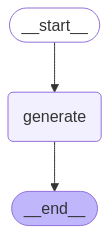

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [12]:
response = graph.invoke({"messages": ["안녕하세요! 저는 이성용입니다"]})

print(type(response))
response

<class 'langgraph.pregel.io.AddableValuesDict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 이성용입니다', additional_kwargs={}, response_metadata={}, id='8ee1a26a-28c9-49ce-a1e5-3f957ece799c'),
  AIMessage(content='안녕하세요, 이성용님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 15, 'total_tokens': 37, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BFX4bRKP0li5nm3kUzSGlhiIy0iQb', 'finish_reason': 'stop', 'logprobs': None}, id='run-256b6755-d559-4484-9509-a43572647fb6-0', usage_metadata={'input_tokens': 15, 'output_tokens': 22, 'total_tokens': 37, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [15]:
for m in response['messages']:
    print(type(m), m.content)

<class 'langchain_core.messages.human.HumanMessage'> 안녕하세요! 저는 이성용입니다
<class 'langchain_core.messages.ai.AIMessage'> 안녕하세요, 이성용님! 만나서 반갑습니다. 어떻게 도와드릴까요?


In [16]:
response["messages"].append("제 이름을 아시나요?")
response = graph.invoke(response)

for m in response['messages']:
    print(type(m), m.content)

<class 'langchain_core.messages.human.HumanMessage'> 안녕하세요! 저는 이성용입니다
<class 'langchain_core.messages.ai.AIMessage'> 안녕하세요, 이성용님! 만나서 반갑습니다. 어떻게 도와드릴까요?
<class 'langchain_core.messages.human.HumanMessage'> 제 이름을 아시나요?
<class 'langchain_core.messages.ai.AIMessage'> 네, 이성용님이라고 말씀하셨습니다. 다른 궁금한 점이나 이야기하고 싶은 것이 있으신가요?


- stream 출력 하고 싶으면 graph.invoke 대신 graph.stream으로 하면 됩니다.

In [17]:
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려줘")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본의 관계는 역사적으로 복잡하고 다양합니다. 두 나라 간의 관계는 여러 측면에서 영향을 받고 있습니다. 여기서는 역사적, 정치적, 경제적, 문화적 측면에서 한국과 일본의 관계를 살펴보겠습니다.

### 1. 역사적 배경
- **고대 및 중세**: 한국과 일본은 고대부터 교류가 있었습니다. 일본은 한국의 고대 문명과 문화의 영향을 받았으며, 특히 한자로써 기록된 문서들이 서로의 문화 교류를 증명합니다.
  
- **일제 강점기**: 1910년부터 1945년까지 일본은 한국을 식민지로 통치했습니다. 이 시기는 한국에 있어 매우 아픈 역사로, 일본의 강제 동원, 자원 착취, 문화 말살 등이 일어났습니다. 이로 인해 한국 내에는 일본에 대한 감정이 부정적이며, 이러한 역사적 경험은 현재까지도 두 국가 간의 관계에 깊은 영향을 미치고 있습니다.

### 2. 정치적 관점
- **관계 개선 노력**: 1965년 한일 기본 조약을 통해 양국은 공식적으로 외교 관계를 재정립하였습니다. 그러나 과거 역사 문제, 특히 위안부와 강제 노동 문제 등은 여전히 갈등의 원인이 되고 있습니다.

- **최근 상황**: 한국과 일본의 정치적 관계는 여러 차례 긴장을 겪었습니다. 특히 2019년 일본의 수출 규제 조치와 그에 따른 한국의 반발이 두 나라 간의 관계를 더욱 악화시켰습니다.

### 3. 경제적 관계
- **무역**: 한국과 일본은 서로에게 중요한 무역 파트너입니다. 일본은 한국의 중요한 수입국이며, 한국은 일본에 대한 여러 산업 제품의 수출국입니다. 그러나 정치적 긴장이 경제 협력에도 부정적인 영향을 미치기도 합니다.

- **기술 협력**: 양국은 기술 및 산업 분야에서 협력할 수 있는 잠재력이 크지만, 정치적 이슈로 인해 이를 최대한 활용하지 못하는 경우가 많습니다.

### 4. 문화적 교류
- **문화 및 대중문화**: 최근 몇 년간 한국의 K-pop, 드라마 등이 일본에서 큰 인기를 얻고 있습니다. 이러한 문화적 교류는 양국 관계 개선에 긍정적인 역할을 하고